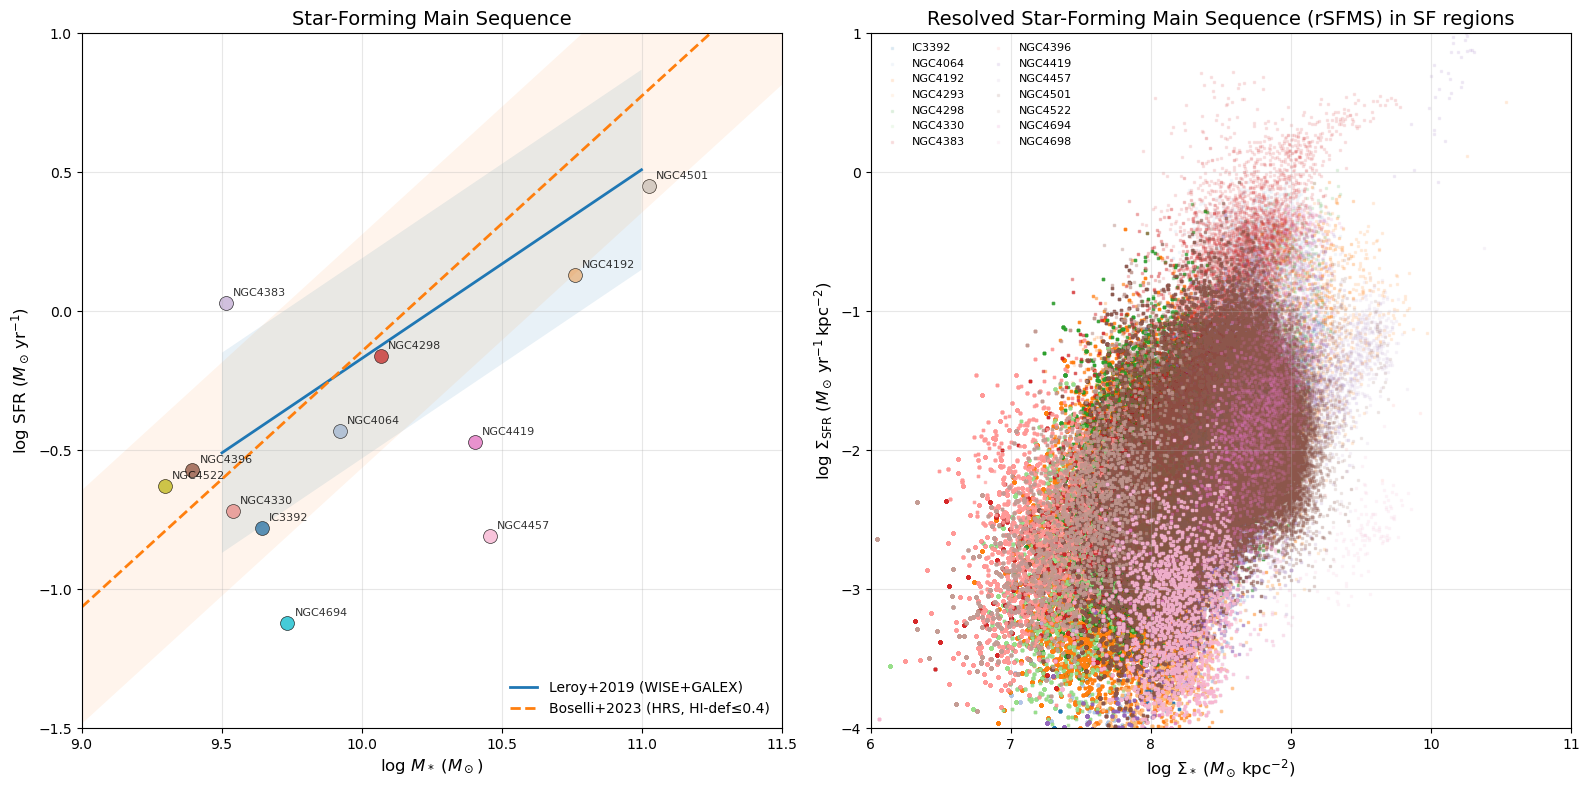

Subplot 1: Plotted 14 galaxies with valid total mass and SFR data
Subplot 2: Plotted spatially-resolved data for 14 galaxies


In [1]:
# ------------------------------------------------------------------
# Combined Plot: Total SFMS + Spatially-resolved Star Formation
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total SFR from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR from SF region:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def sfms_leroy2019(logM, scatter=0.36, valid=(9.5, 11.0)):
    """Leroy+2019 eq.19 converted to log SFR: logSFR = 0.68*logM - 6.97."""
    y = 0.68 * np.asarray(logM) - 6.97
    # mask outside their stated mass range
    y = np.where((logM < valid[0]) | (logM > valid[1]), np.nan, y)
    return y

def sfms_boselli2023(logM, slope=0.92, intercept=-1.57, x_pivot=8.451, scatter=0.42):
    """
    Boselli+2023 (HRS, HI-def ≤ 0.4): fit with pivot x_pivot.
    y = slope * (logM - x_pivot) + intercept
    """
    logM = np.asarray(logM)
    y = slope * (logM - x_pivot) + intercept
    return y

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Extract total masses and SFRs
log_masses = []
log_sfrs = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    sfr = extract_total_sfr(gal)
    
    if mass is not None and sfr is not None:
        log_masses.append(mass)
        log_sfrs.append(sfr)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
log_sfrs = np.array(log_sfrs)

# Color-code each galaxy
colors_total = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names)))

# Plot points and add galaxy names as annotations
for i, (mass, sfr, gal) in enumerate(zip(log_masses, log_sfrs, galaxy_names)):
    # Plot the point
    ax1.scatter(mass, sfr, s=100, c=[colors_total[i]], alpha=0.8, 
               edgecolors='black', linewidth=0.5)
    
    # Add galaxy name as annotation with slight offset
    ax1.annotate(gal, (mass, sfr), xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'$\log\,\mathrm{SFR} \; (M_\odot\,\mathrm{yr}^{-1})$', fontsize=12)
ax1.set_title('Star-Forming Main Sequence', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(-1.5, 1)

# Add SFMS relations
x_line = np.linspace(*ax1.get_xlim(), 400)

# Leroy+2019 line + ±0.36 dex band
y_l19 = sfms_leroy2019(x_line)
ax1.plot(x_line, y_l19, lw=2, ls='-', label='Leroy+2019 (WISE+GALEX)')
ax1.fill_between(x_line, y_l19 - 0.36, y_l19 + 0.36, alpha=0.10, linewidth=0)

# Boselli+2023 line + intrinsic-scatter band
y_b23 = sfms_boselli2023(x_line)
ax1.plot(x_line, y_b23, lw=2, ls='--', label='Boselli+2023 (HRS, HI-def≤0.4)')
ax1.fill_between(x_line, y_b23 - 0.42, y_b23 + 0.42, alpha=0.08, linewidth=0)

# Add legend for SFMS relations
ax1.legend(frameon=False, fontsize=10, loc='lower right')

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs ΣSFR
# ------------------------------------------------------------------

# Colour cycle for spatially-resolved plot
colors_spatial = itertools.cycle(plt.get_cmap('tab20').colors)

# Collect all data points for global fit
all_x = []
all_y = []

for gal, colour in zip(galaxies, colors_spatial):
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            logSigmaSFR = hdul['LOGSFR_SURFACE_DENSITY_SF'].data  # Σ_SFR

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(logSigmaSFR)

        # Scatter plot
        ax2.scatter(
            logSigmaM[good],
            logSigmaSFR[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=colour,
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(logSigmaSFR[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'$\log\,\Sigma_{\mathrm{SFR}}\; (M_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_title(r'Resolved Star-Forming Main Sequence (rSFMS) in SF regions', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(-4, 1)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and SFR data")
print(f"Subplot 2: Plotted spatially-resolved data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

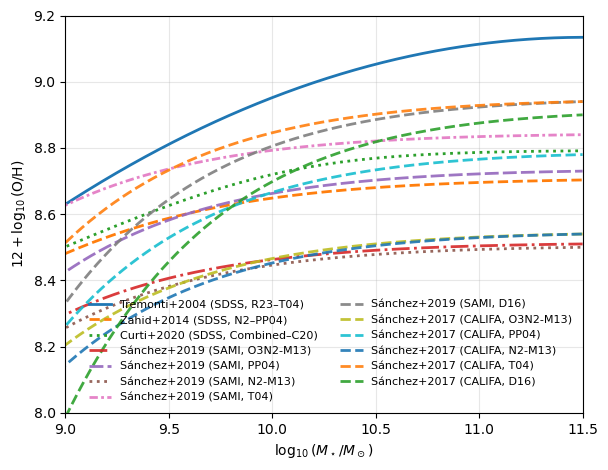

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2, fontsize=8)
    plt.tight_layout()
    return ax

# Example
if __name__ == "__main__":
    plot_previous_MZR(
        sanchez2017_calibs=("O3N2-M13","PP04","N2-M13","T04","D16")
    )
    plt.show()


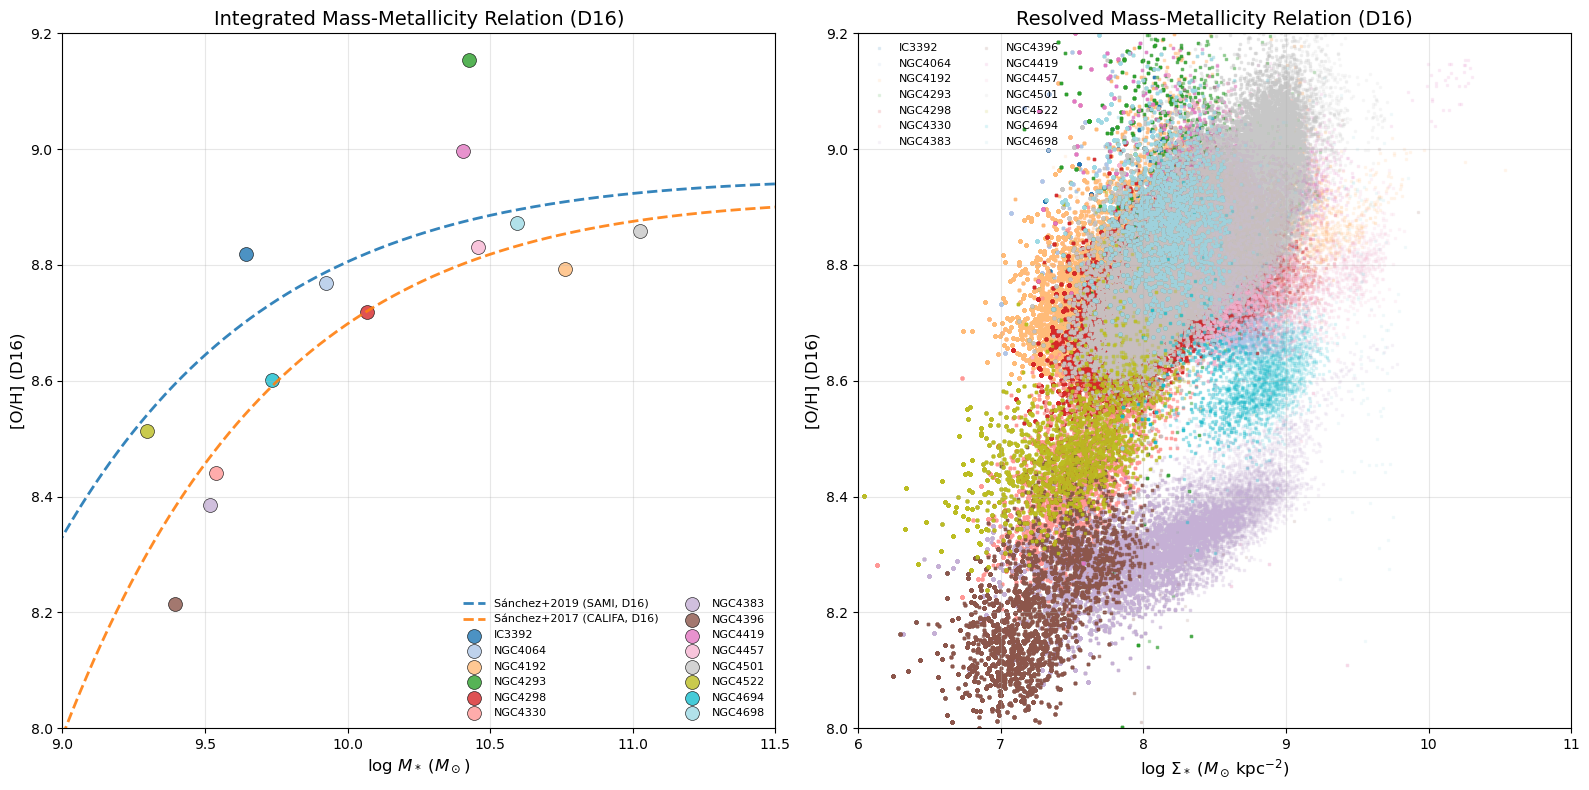

Subplot 1: Plotted 14 galaxies with valid total mass and D16 metallicity data
Subplot 2: Plotted spatially-resolved D16 MZR data for 14 galaxies


In [3]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (D16) + Resolved MZR (D16)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total D16 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_d16_metallicity(galaxy_name):
    """Extract total D16 metallicity from log file. Returns [O/H] D16 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] D16: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading D16 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and D16 metallicities
log_masses = []
d16_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_d16_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        d16_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
d16_metallicities = np.array(d16_metallicities)

# Plot reference MZR relations from literature (D16-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("D16",), sanchez2017_calibs=("D16",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, d16_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (D16)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] D16
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_d16 = hdul['O_H_D16_SF'].data  # [O/H] D16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_d16)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_d16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_d16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (D16)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and D16 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved D16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

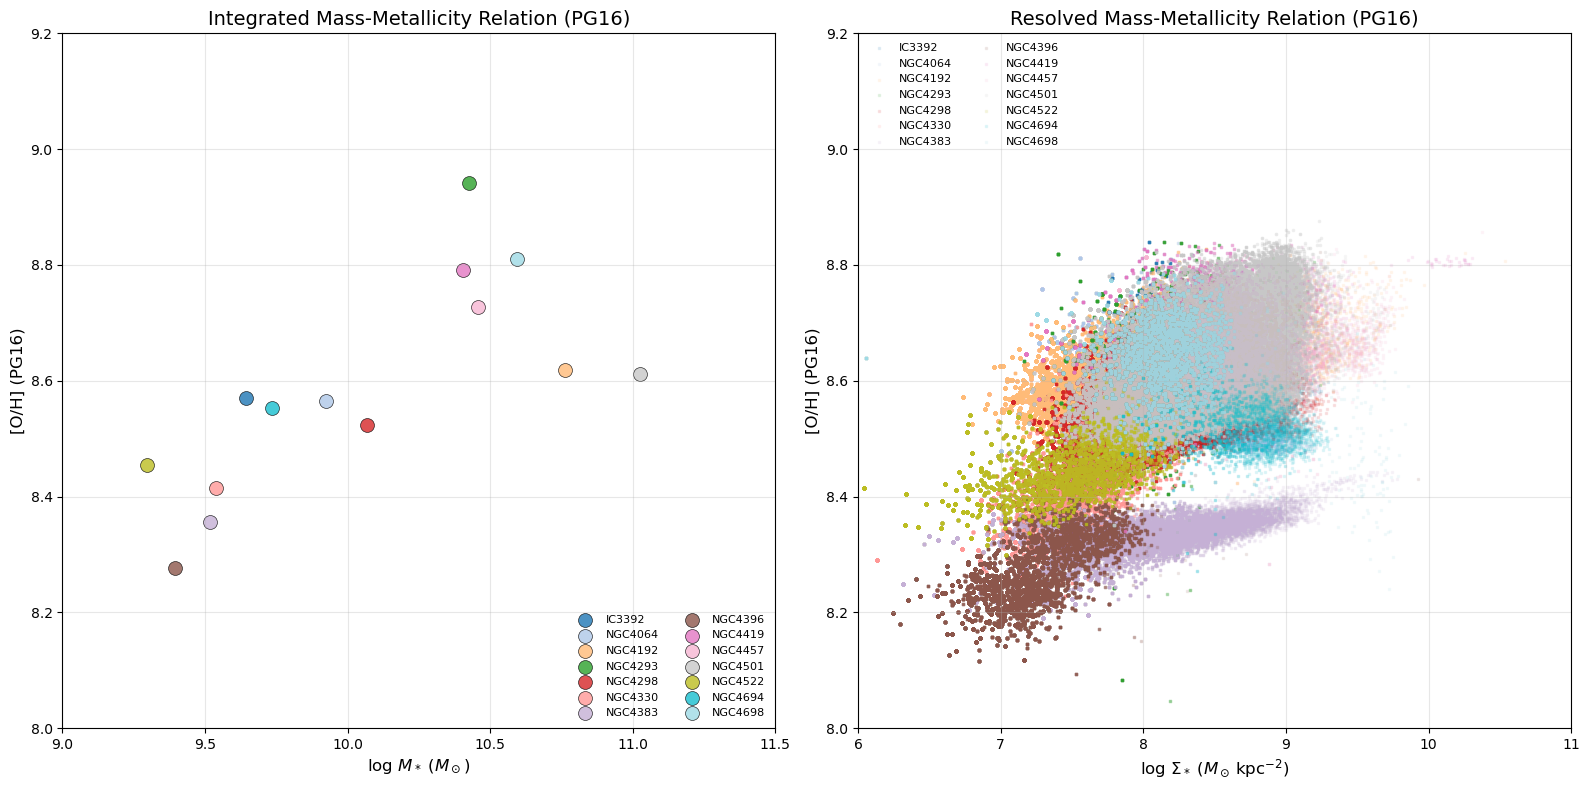

Subplot 1: Plotted 14 galaxies with valid total mass and PG16 metallicity data
Subplot 2: Plotted spatially-resolved PG16 MZR data for 14 galaxies


In [4]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (PG16) + Resolved MZR (PG16)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total PG16 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_pg16_metallicity(galaxy_name):
    """Extract total PG16 metallicity from log file. Returns [O/H] PG16 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] PG16: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading PG16 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and PG16 metallicities
log_masses = []
pg16_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_pg16_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        pg16_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
pg16_metallicities = np.array(pg16_metallicities)

# Plot reference MZR relations from literature (PG16/PP04-relevant only)
# plot_previous_MZR(ax=ax1, show_legend=False, include=('Z14',), sanchez_calibs=("PP04",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, pg16_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (PG16)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] PG16
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_pg16 = hdul['O_H_PG16_SF'].data  # [O/H] PG16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_pg16)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_pg16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_pg16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (PG16)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and PG16 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved PG16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

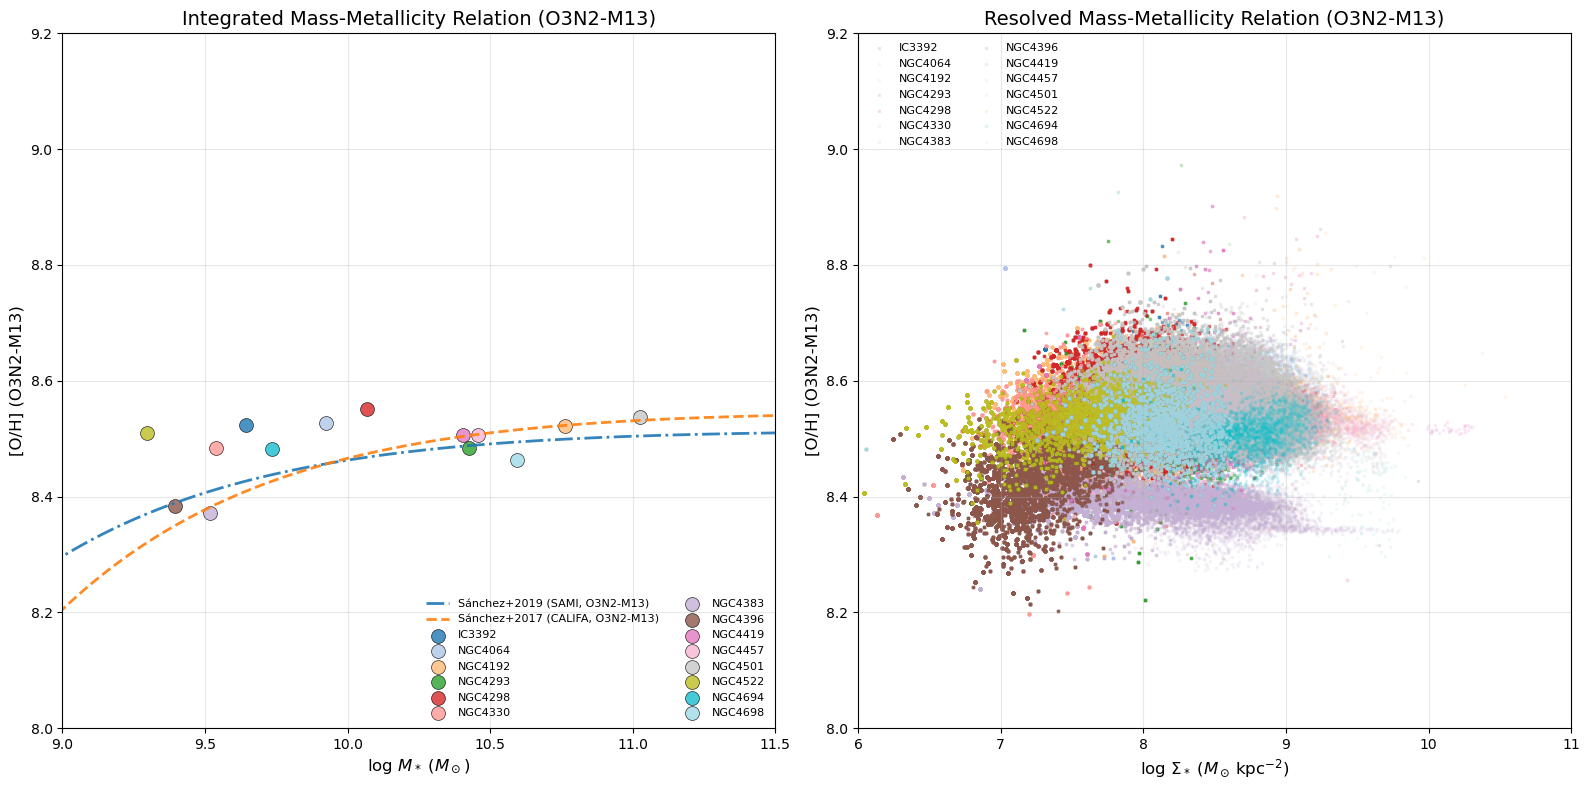

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-M13 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-M13 MZR data for 14 galaxies


In [5]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-M13) + Resolved MZR (O3N2-M13)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-M13 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_m13_metallicity(galaxy_name):
    """Extract total O3N2-M13 metallicity from log file. Returns [O/H] O3N2-M13 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-M13: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-M13 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-M13 metallicities
log_masses = []
o3n2_m13_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_m13_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_m13_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_m13_metallicities = np.array(o3n2_m13_metallicities)

# Plot reference MZR relations from literature (O3N2-M13-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("O3N2-M13",), sanchez2017_calibs=("O3N2-M13",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_m13_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-M13)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-M13
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_m13 = hdul['O_H_O3N2_M13_SF'].data  # [O/H] O3N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_m13)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-M13)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-M13 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

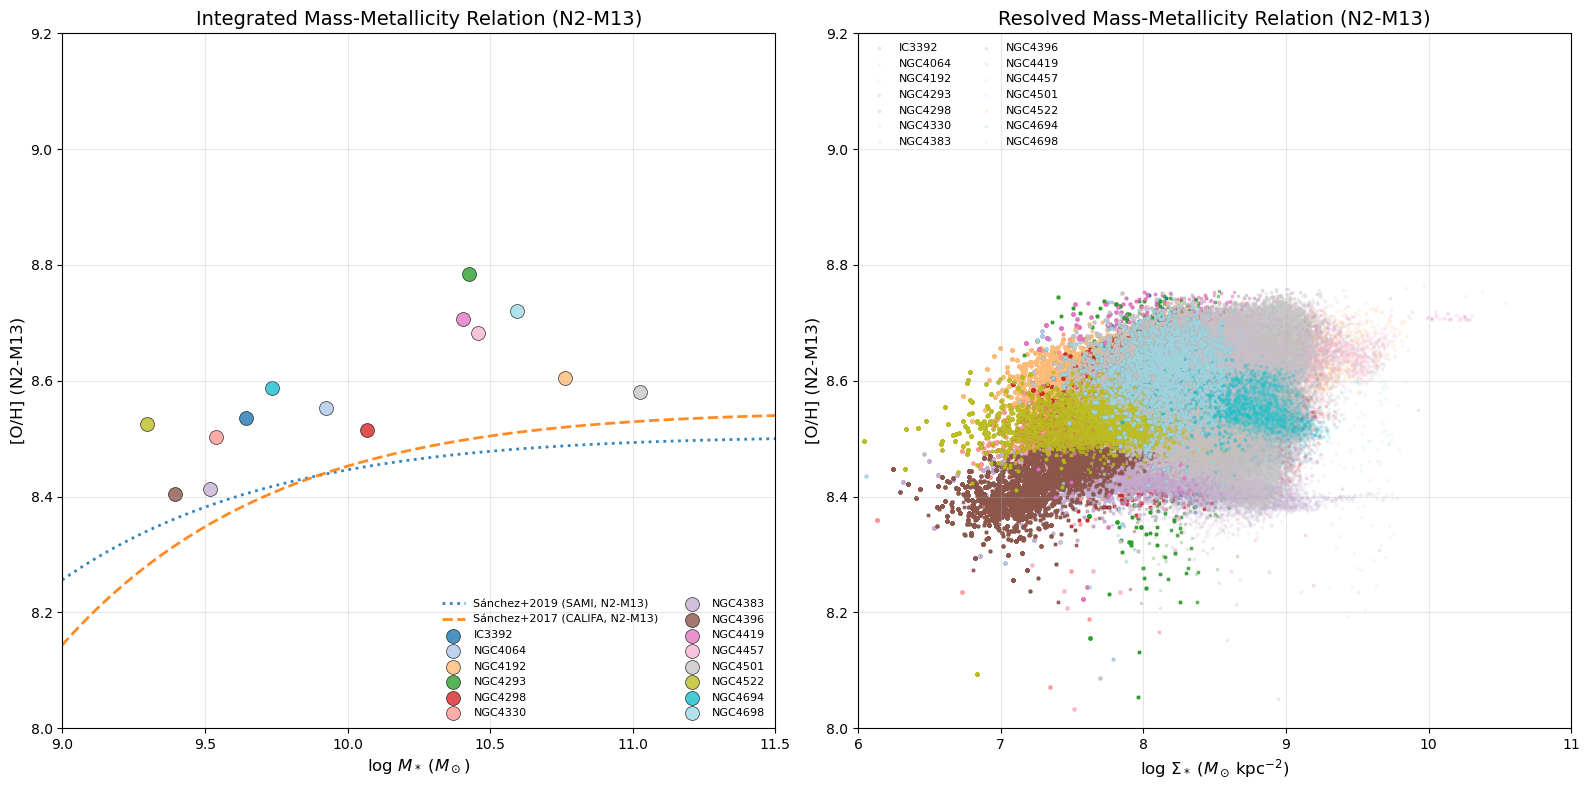

Subplot 1: Plotted 14 galaxies with valid total mass and N2-M13 metallicity data
Subplot 2: Plotted spatially-resolved N2-M13 MZR data for 14 galaxies


In [6]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-M13) + Resolved MZR (N2-M13)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-M13 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_m13_metallicity(galaxy_name):
    """Extract total N2-M13 metallicity from log file. Returns [O/H] N2-M13 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-M13: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-M13 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-M13 metallicities
log_masses = []
n2_m13_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_m13_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_m13_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_m13_metallicities = np.array(n2_m13_metallicities)

# Plot reference MZR relations from literature (N2-M13-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("N2-M13",), sanchez2017_calibs=("N2-M13",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_m13_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-M13)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-M13
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_m13 = hdul['O_H_N2_M13_SF'].data  # [O/H] N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_m13)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-M13)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-M13 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

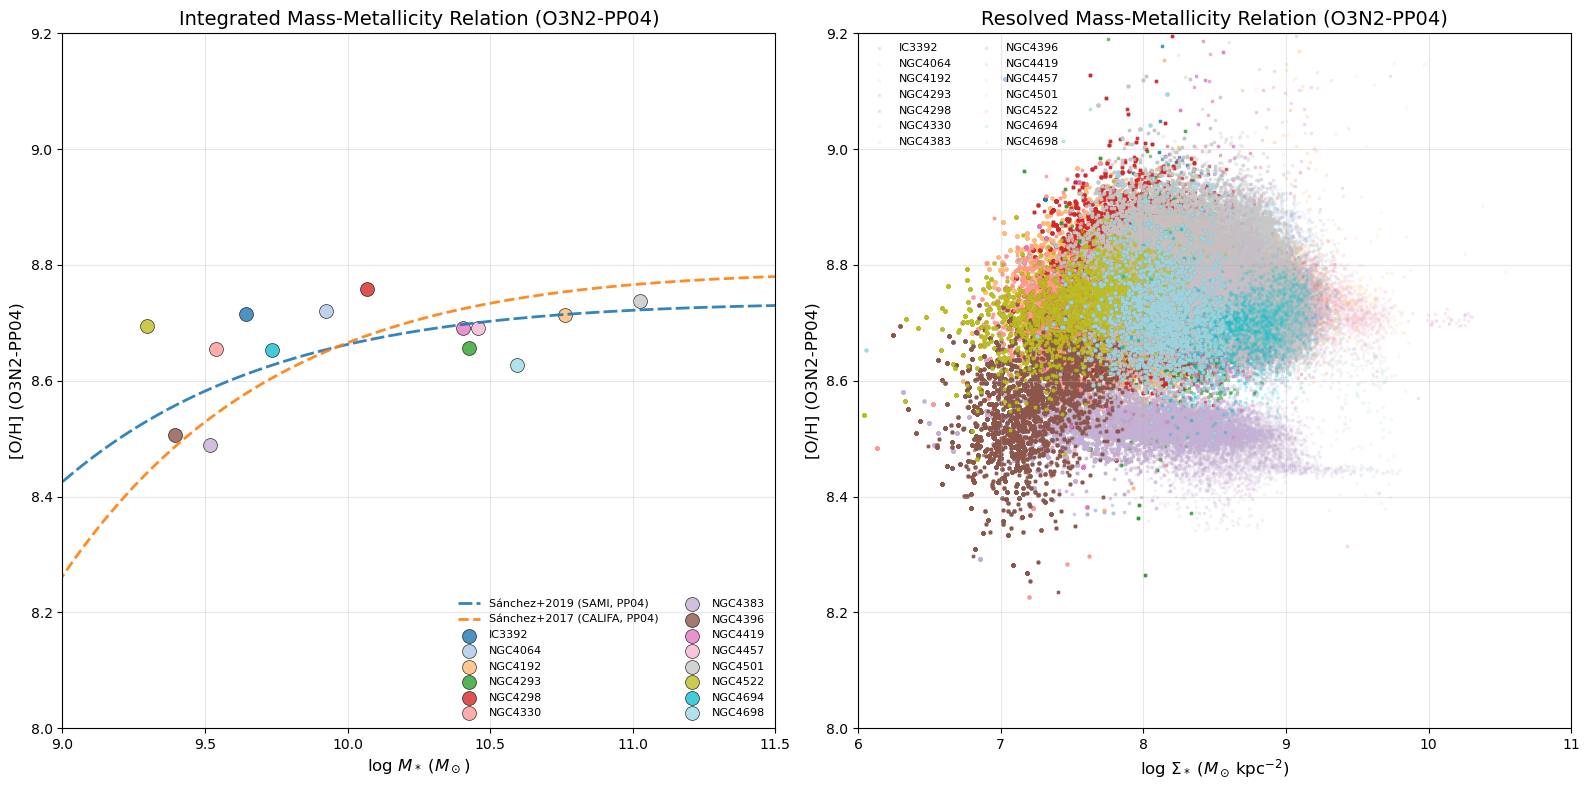

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-PP04 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-PP04 MZR data for 14 galaxies


In [7]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-PP04) + Resolved MZR (O3N2-PP04)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-PP04 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_pp04_metallicity(galaxy_name):
    """Extract total O3N2-PP04 metallicity from log file. Returns [O/H] O3N2-PP04 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-PP04: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-PP04 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-PP04 metallicities
log_masses = []
o3n2_pp04_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_pp04_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_pp04_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_pp04_metallicities = np.array(o3n2_pp04_metallicities)

# Plot reference MZR relations from literature (O3N2-PP04-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("PP04",), sanchez2017_calibs=("PP04",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_pp04_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-PP04)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-PP04
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_pp04 = hdul['O_H_O3N2_PP04_SF'].data  # [O/H] O3N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_pp04)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-PP04)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-PP04 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

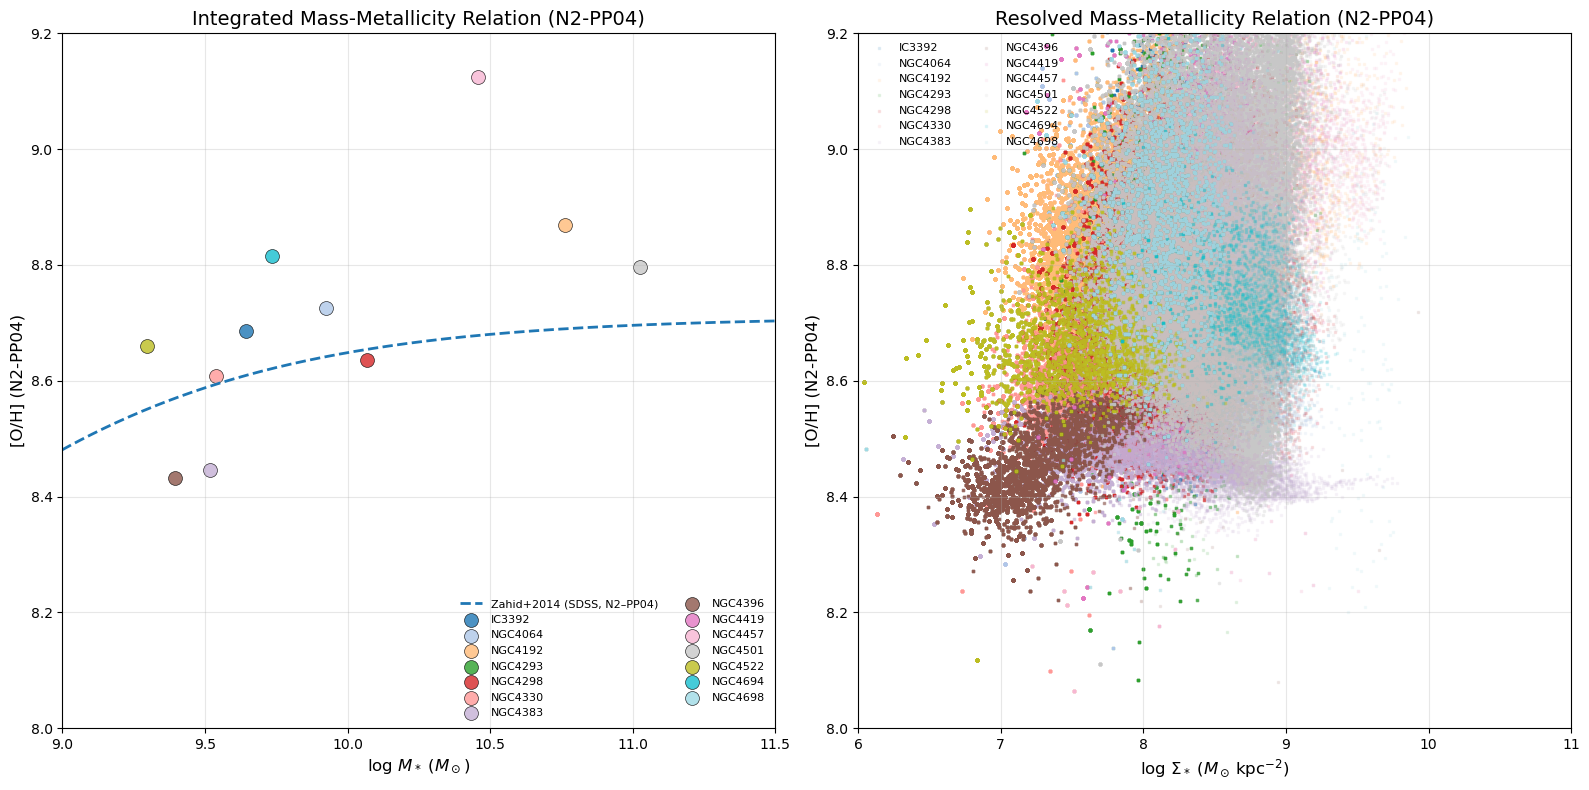

Subplot 1: Plotted 14 galaxies with valid total mass and N2-PP04 metallicity data
Subplot 2: Plotted spatially-resolved N2-PP04 MZR data for 14 galaxies


In [8]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-PP04) + Resolved MZR (N2-PP04)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-PP04 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_pp04_metallicity(galaxy_name):
    """Extract total N2-PP04 metallicity from log file. Returns [O/H] N2-PP04 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-PP04: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-PP04 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-PP04 metallicities
log_masses = []
n2_pp04_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_pp04_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_pp04_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_pp04_metallicities = np.array(n2_pp04_metallicities)

# Plot reference MZR relations from literature (N2-PP04-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('Z14',), sanchez_calibs=(), sanchez2017_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_pp04_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-PP04)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-PP04
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_pp04 = hdul['O_H_N2_PP04_SF'].data  # [O/H] N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_pp04)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-PP04)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-PP04 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

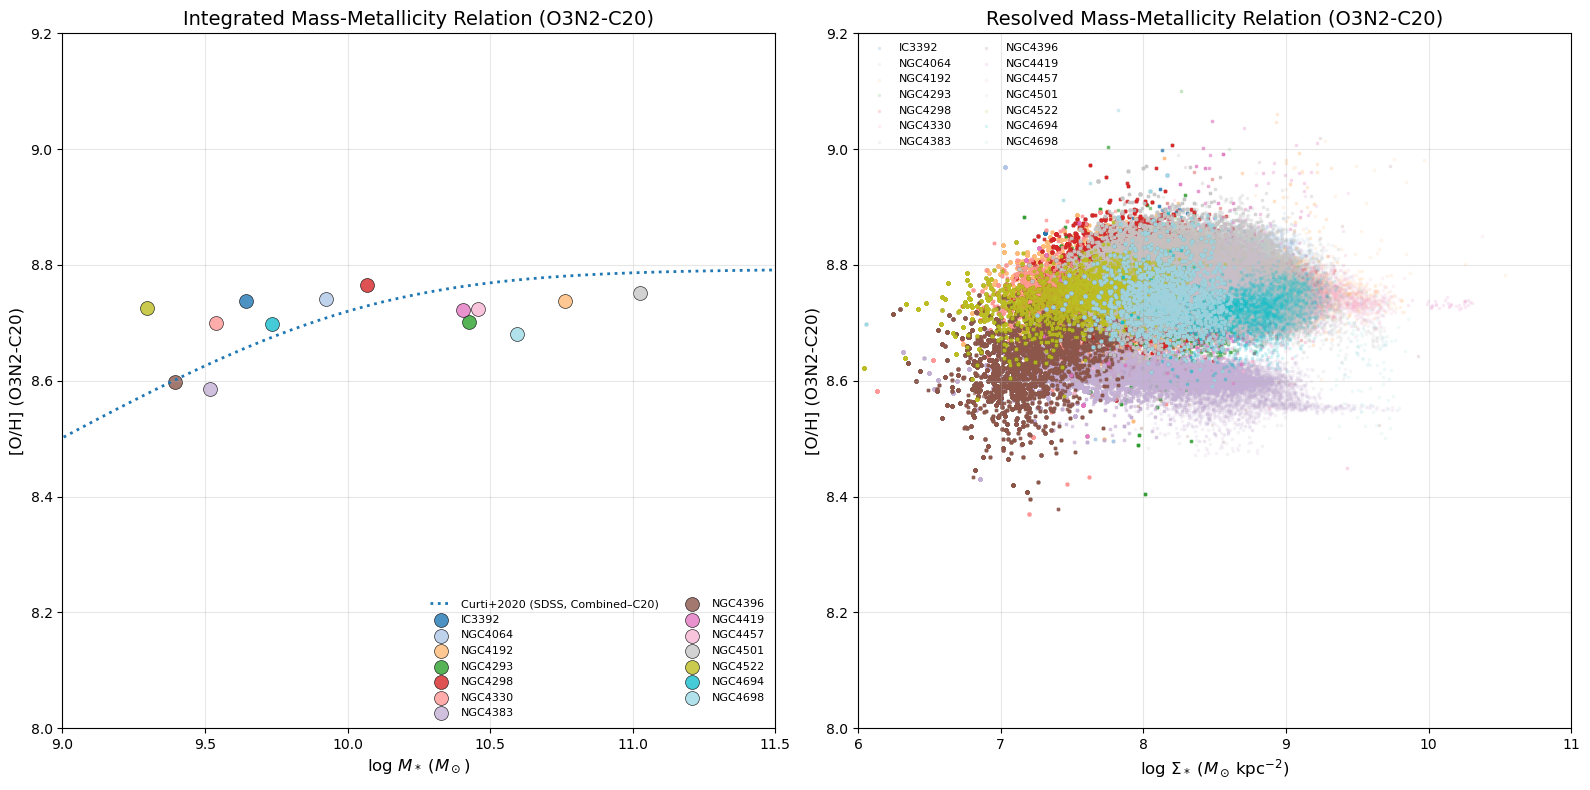

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-C20 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-C20 MZR data for 14 galaxies


In [9]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-C20) + Resolved MZR (O3N2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Define MZR functions from literature
def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.53, b=0.012),
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04": "--", 
    "N2-M13": ":",
    "T04": "-",
    "D16": "-",
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    if show_legend:
        ax.legend(frameon=False, ncol=2)
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_c20_metallicity(galaxy_name):
    """Extract total O3N2-C20 metallicity from log file. Returns [O/H] O3N2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-C20 metallicities
log_masses = []
o3n2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_c20_metallicities = np.array(o3n2_c20_metallicities)

# Plot reference MZR relations from literature (O3N2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_c20 = hdul['O_H_O3N2_C20_SF'].data  # [O/H] O3N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

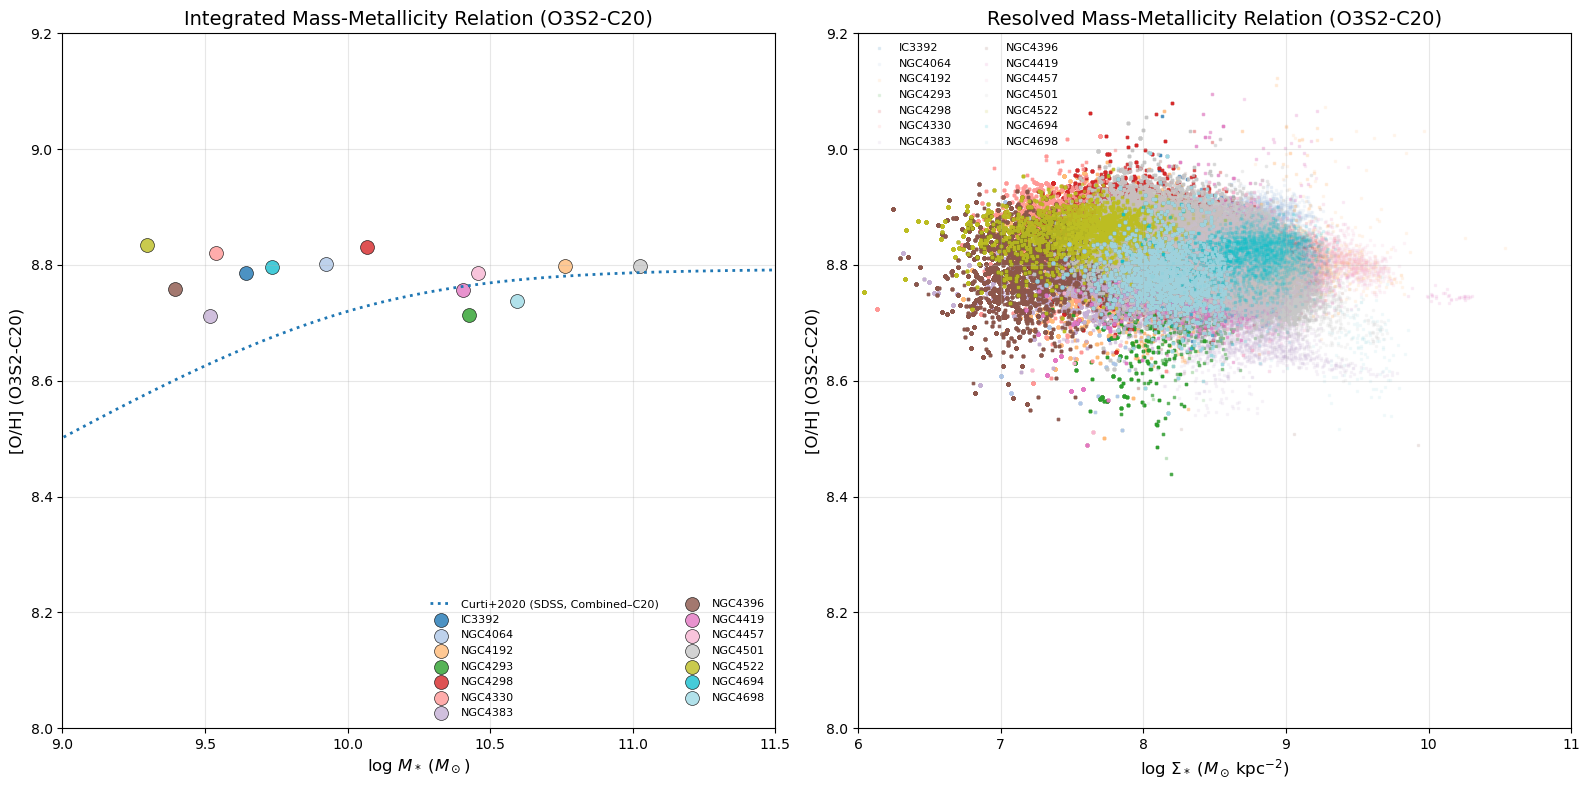

Subplot 1: Plotted 14 galaxies with valid total mass and O3S2-C20 metallicity data
Subplot 2: Plotted spatially-resolved O3S2-C20 MZR data for 14 galaxies


In [10]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3S2-C20) + Resolved MZR (O3S2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3S2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3s2_c20_metallicity(galaxy_name):
    """Extract total O3S2-C20 metallicity from log file. Returns [O/H] O3S2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3S2-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3S2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3S2-C20 metallicities
log_masses = []
o3s2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3s2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3s2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3s2_c20_metallicities = np.array(o3s2_c20_metallicities)

# Plot reference MZR relations from literature (O3S2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3s2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3S2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3S2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3s2_c20 = hdul['O_H_O3S2_C20_SF'].data  # [O/H] O3S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3s2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3S2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3S2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

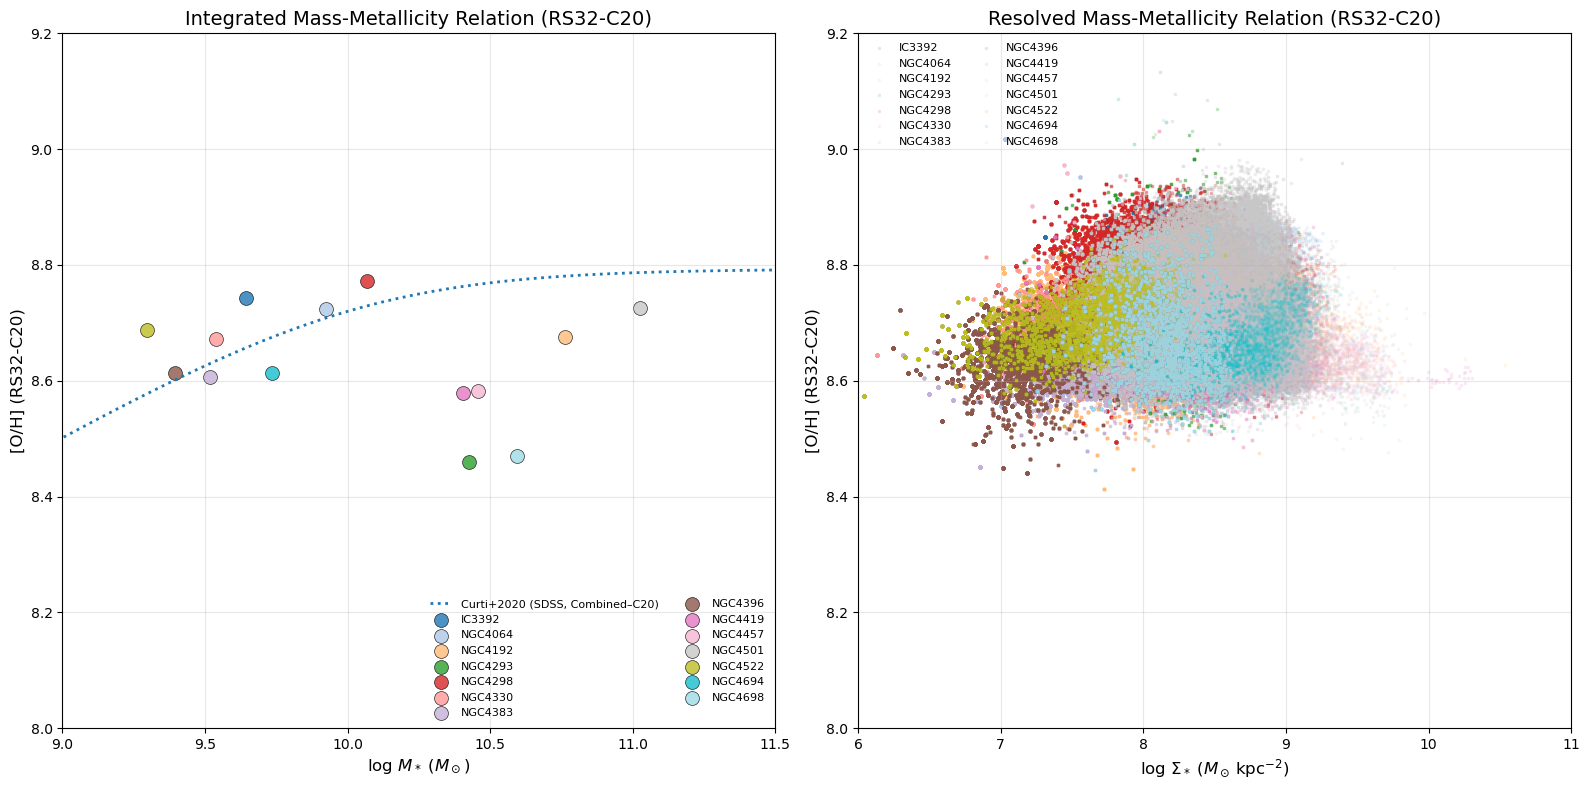

Subplot 1: Plotted 14 galaxies with valid total mass and RS32-C20 metallicity data
Subplot 2: Plotted spatially-resolved RS32-C20 MZR data for 14 galaxies


In [11]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (RS32-C20) + Resolved MZR (RS32-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total RS32-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_rs32_c20_metallicity(galaxy_name):
    """Extract total RS32-C20 metallicity from log file. Returns [O/H] RS32-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] RS32-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading RS32-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and RS32-C20 metallicities
log_masses = []
rs32_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_rs32_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        rs32_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
rs32_c20_metallicities = np.array(rs32_c20_metallicities)

# Plot reference MZR relations from literature (RS32-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, rs32_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (RS32-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] RS32-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_rs32_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] RS32-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_rs32_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_rs32_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_rs32_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (RS32-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and RS32-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved RS32-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

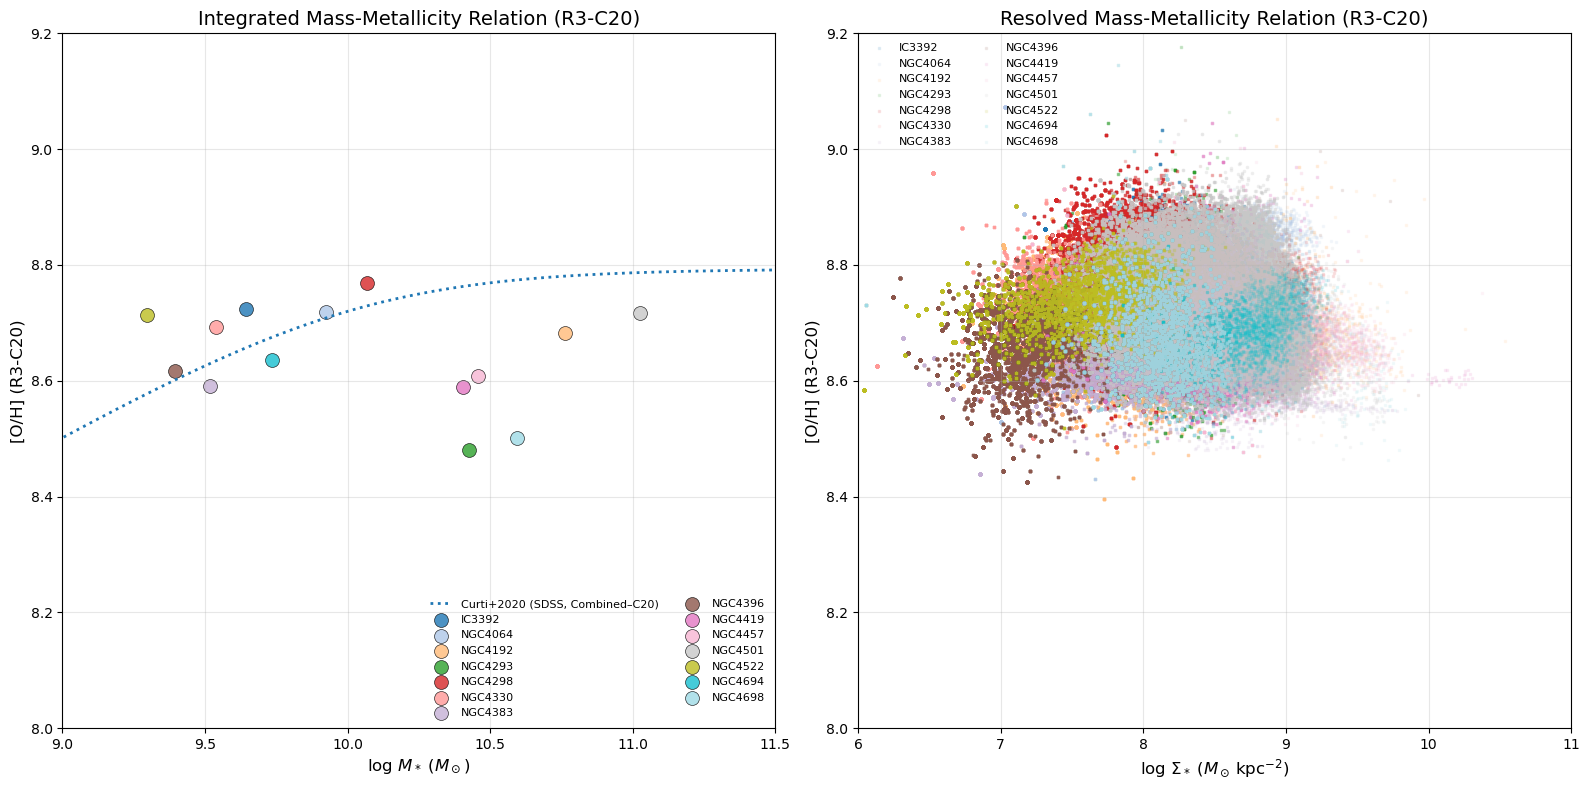

Subplot 1: Plotted 14 galaxies with valid total mass and R3-C20 metallicity data
Subplot 2: Plotted spatially-resolved R3-C20 MZR data for 14 galaxies


In [12]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (R3-C20) + Resolved MZR (R3-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total R3-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_r3_c20_metallicity(galaxy_name):
    """Extract total R3-C20 metallicity from log file. Returns [O/H] R3-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] R3-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading R3-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and R3-C20 metallicities
log_masses = []
r3_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_r3_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        r3_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
r3_c20_metallicities = np.array(r3_c20_metallicities)

# Plot reference MZR relations from literature (R3-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, r3_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (R3-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] R3-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_r3_c20 = hdul['O_H_R3_C20_SF'].data  # [O/H] R3-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_r3_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_r3_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_r3_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (R3-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and R3-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved R3-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

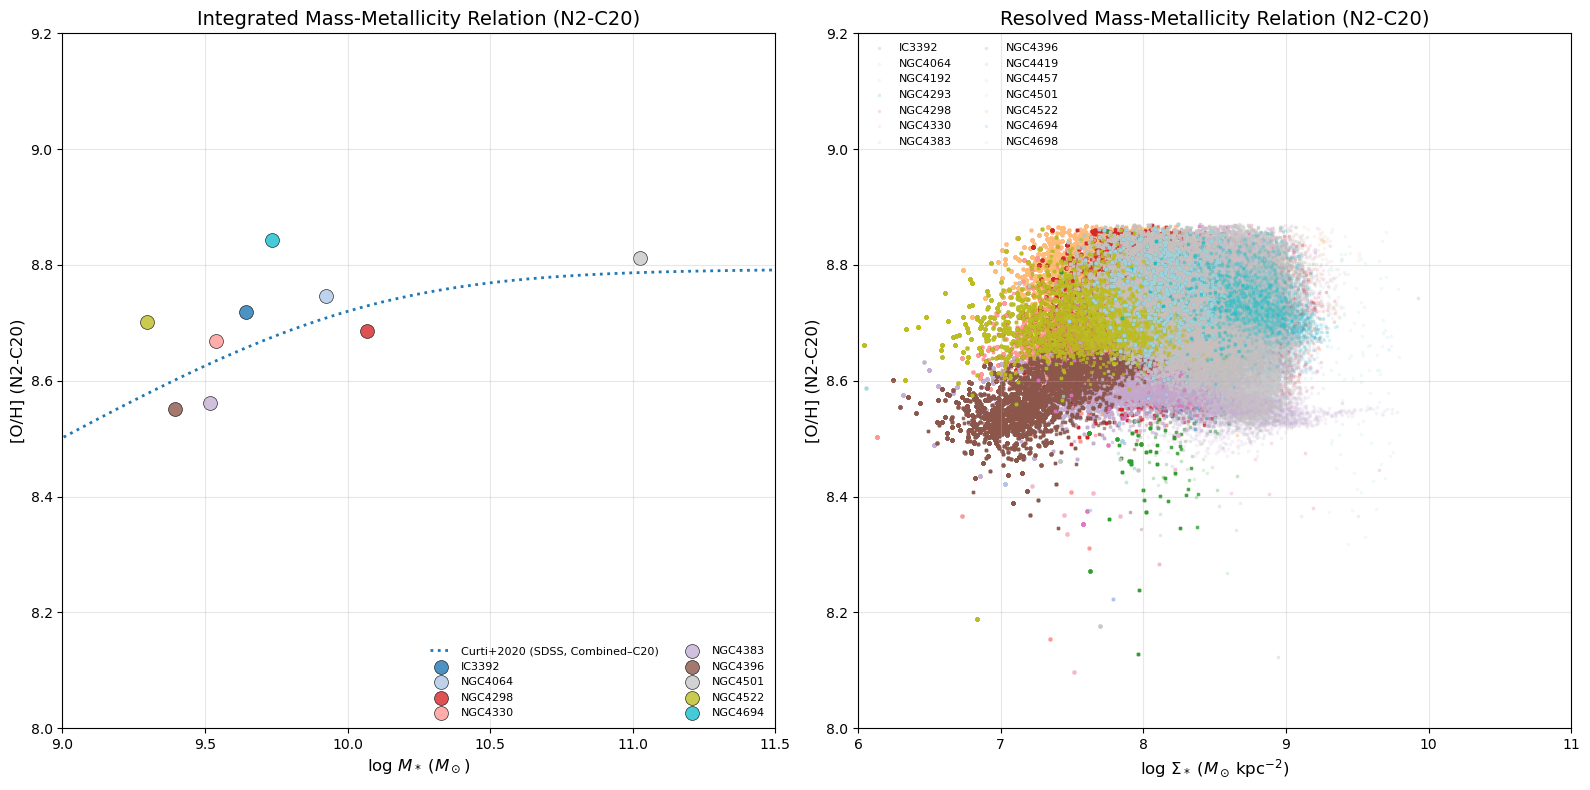

Subplot 1: Plotted 9 galaxies with valid total mass and N2-C20 metallicity data
Subplot 2: Plotted spatially-resolved N2-C20 MZR data for 14 galaxies


In [13]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-C20) + Resolved MZR (N2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_c20_metallicity(galaxy_name):
    """Extract total N2-C20 metallicity from log file. Returns [O/H] N2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-C20 metallicities
log_masses = []
n2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_c20_metallicities = np.array(n2_c20_metallicities)

# Plot reference MZR relations from literature (N2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_c20 = hdul['O_H_N2_C20_SF'].data  # [O/H] N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

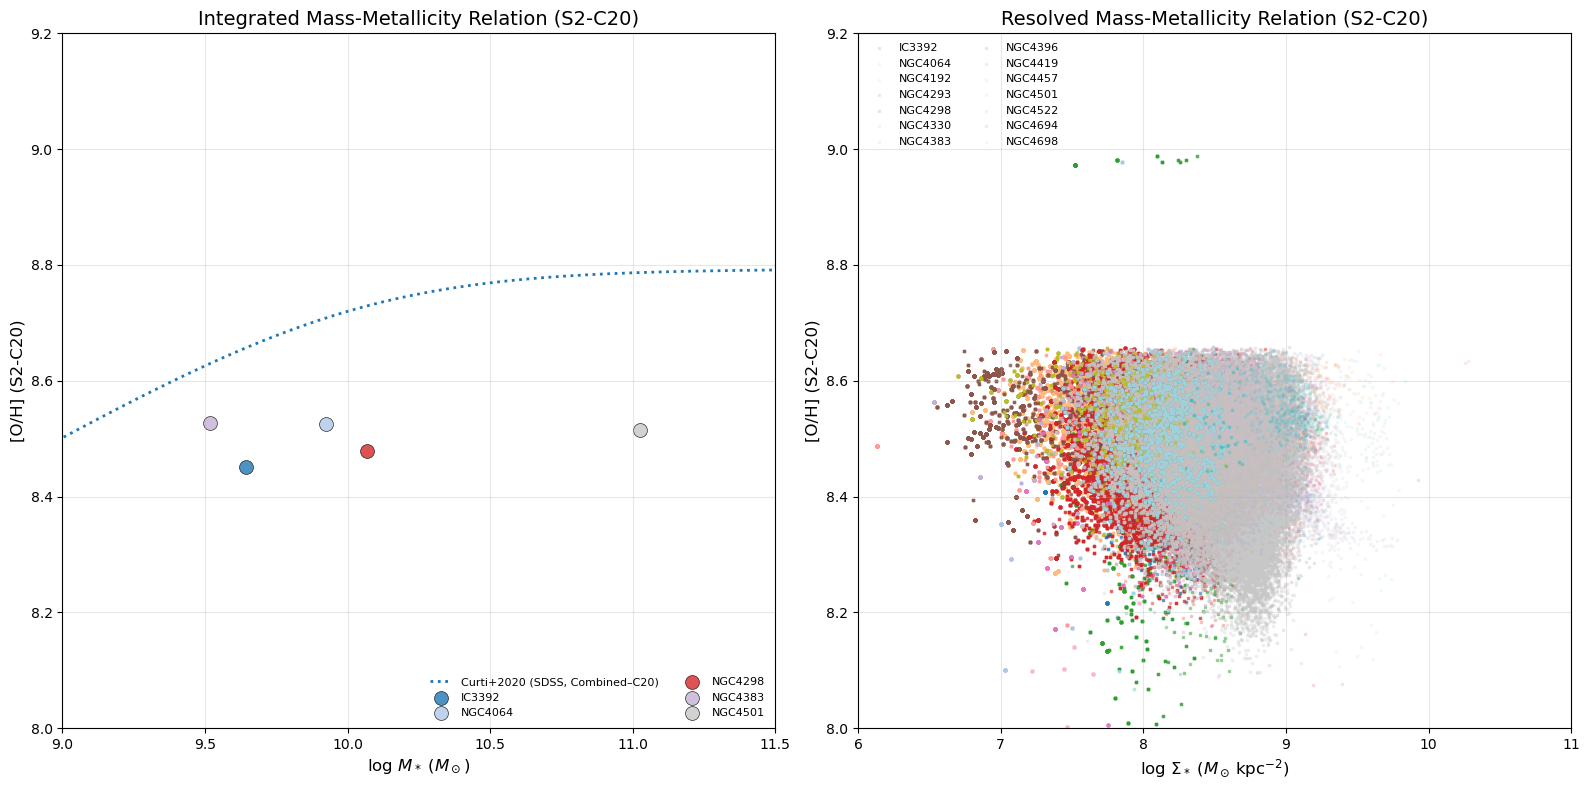

Subplot 1: Plotted 5 galaxies with valid total mass and S2-C20 metallicity data
Subplot 2: Plotted spatially-resolved S2-C20 MZR data for 14 galaxies


In [14]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (S2-C20) + Resolved MZR (S2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total S2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_s2_c20_metallicity(galaxy_name):
    """Extract total S2-C20 metallicity from log file. Returns [O/H] S2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] S2-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading S2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and S2-C20 metallicities
log_masses = []
s2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_s2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        s2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
s2_c20_metallicities = np.array(s2_c20_metallicities)

# Plot reference MZR relations from literature (S2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, s2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (S2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] S2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_s2_c20 = hdul['O_H_S2_C20_SF'].data  # [O/H] S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_s2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (S2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and S2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

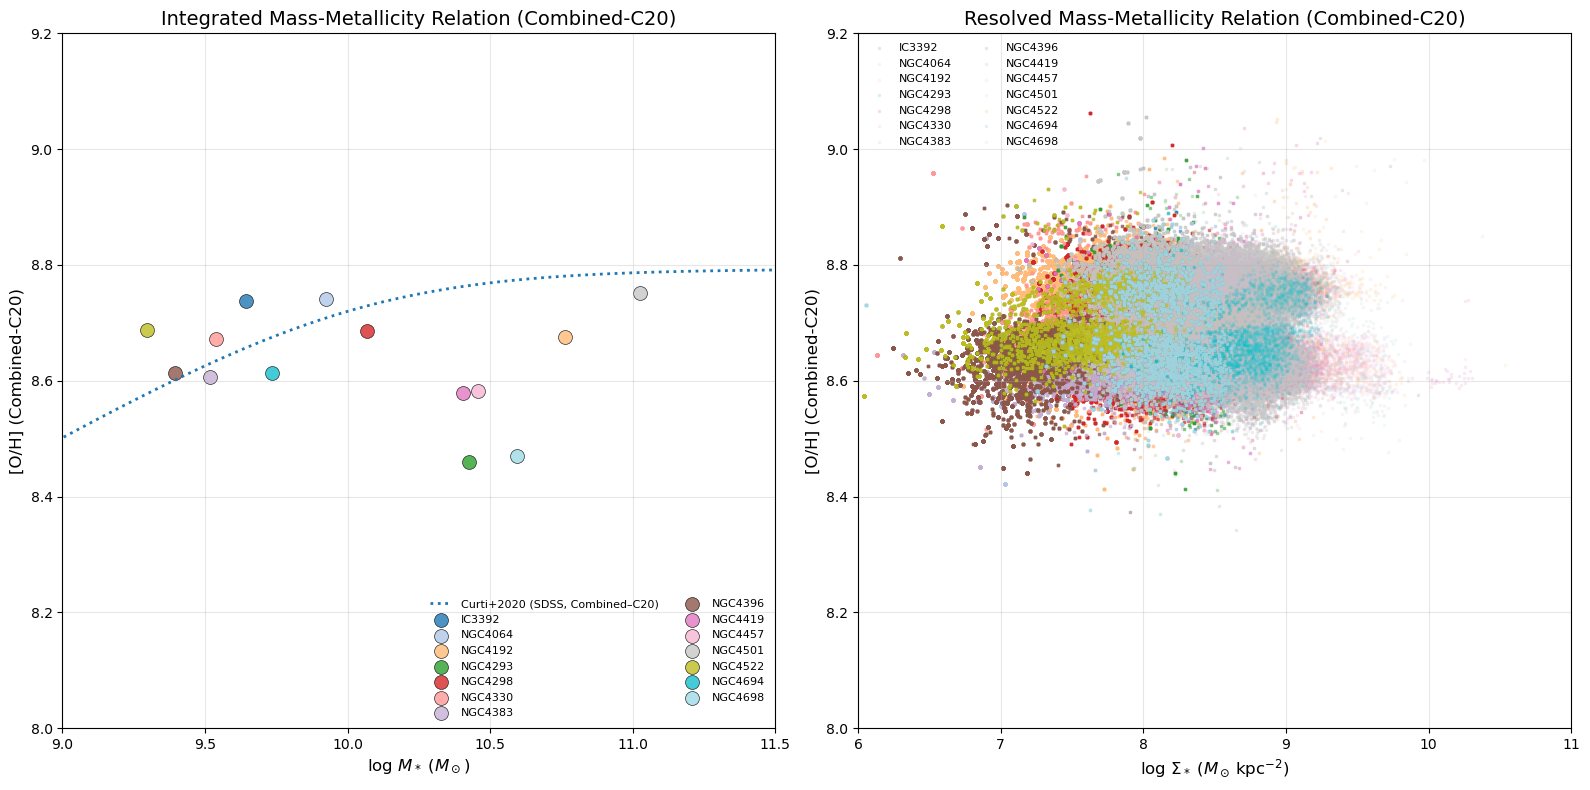

Subplot 1: Plotted 14 galaxies with valid total mass and Combined-C20 metallicity data
Subplot 2: Plotted spatially-resolved Combined-C20 MZR data for 14 galaxies


In [15]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (Combined-C20) + Resolved MZR (Combined-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total Combined-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_combined_c20_metallicity(galaxy_name):
    """Extract total Combined-C20 metallicity from log file. Returns [O/H] Combined-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] Combined-C20: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading Combined-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and Combined-C20 metallicities
log_masses = []
combined_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_combined_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        combined_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
combined_c20_metallicities = np.array(combined_c20_metallicities)

# Plot reference MZR relations from literature (Combined-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, combined_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (Combined-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] Combined-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_combined_c20 = hdul['O_H_COMBINED_C20_SF'].data  # [O/H] Combined-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_combined_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_combined_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_combined_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (Combined-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and Combined-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved Combined-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")


Processing D16 calibration...

Processing PG16 calibration...

Processing O3N2-M13 calibration...

Processing N2-M13 calibration...

Processing O3N2-PP04 calibration...

Processing N2-PP04 calibration...

Processing O3N2-C20 calibration...

Processing O3S2-C20 calibration...

Processing RS32-C20 calibration...

Processing R3-C20 calibration...

Processing N2-C20 calibration...

Processing S2-C20 calibration...

Processing Combined-C20 calibration...


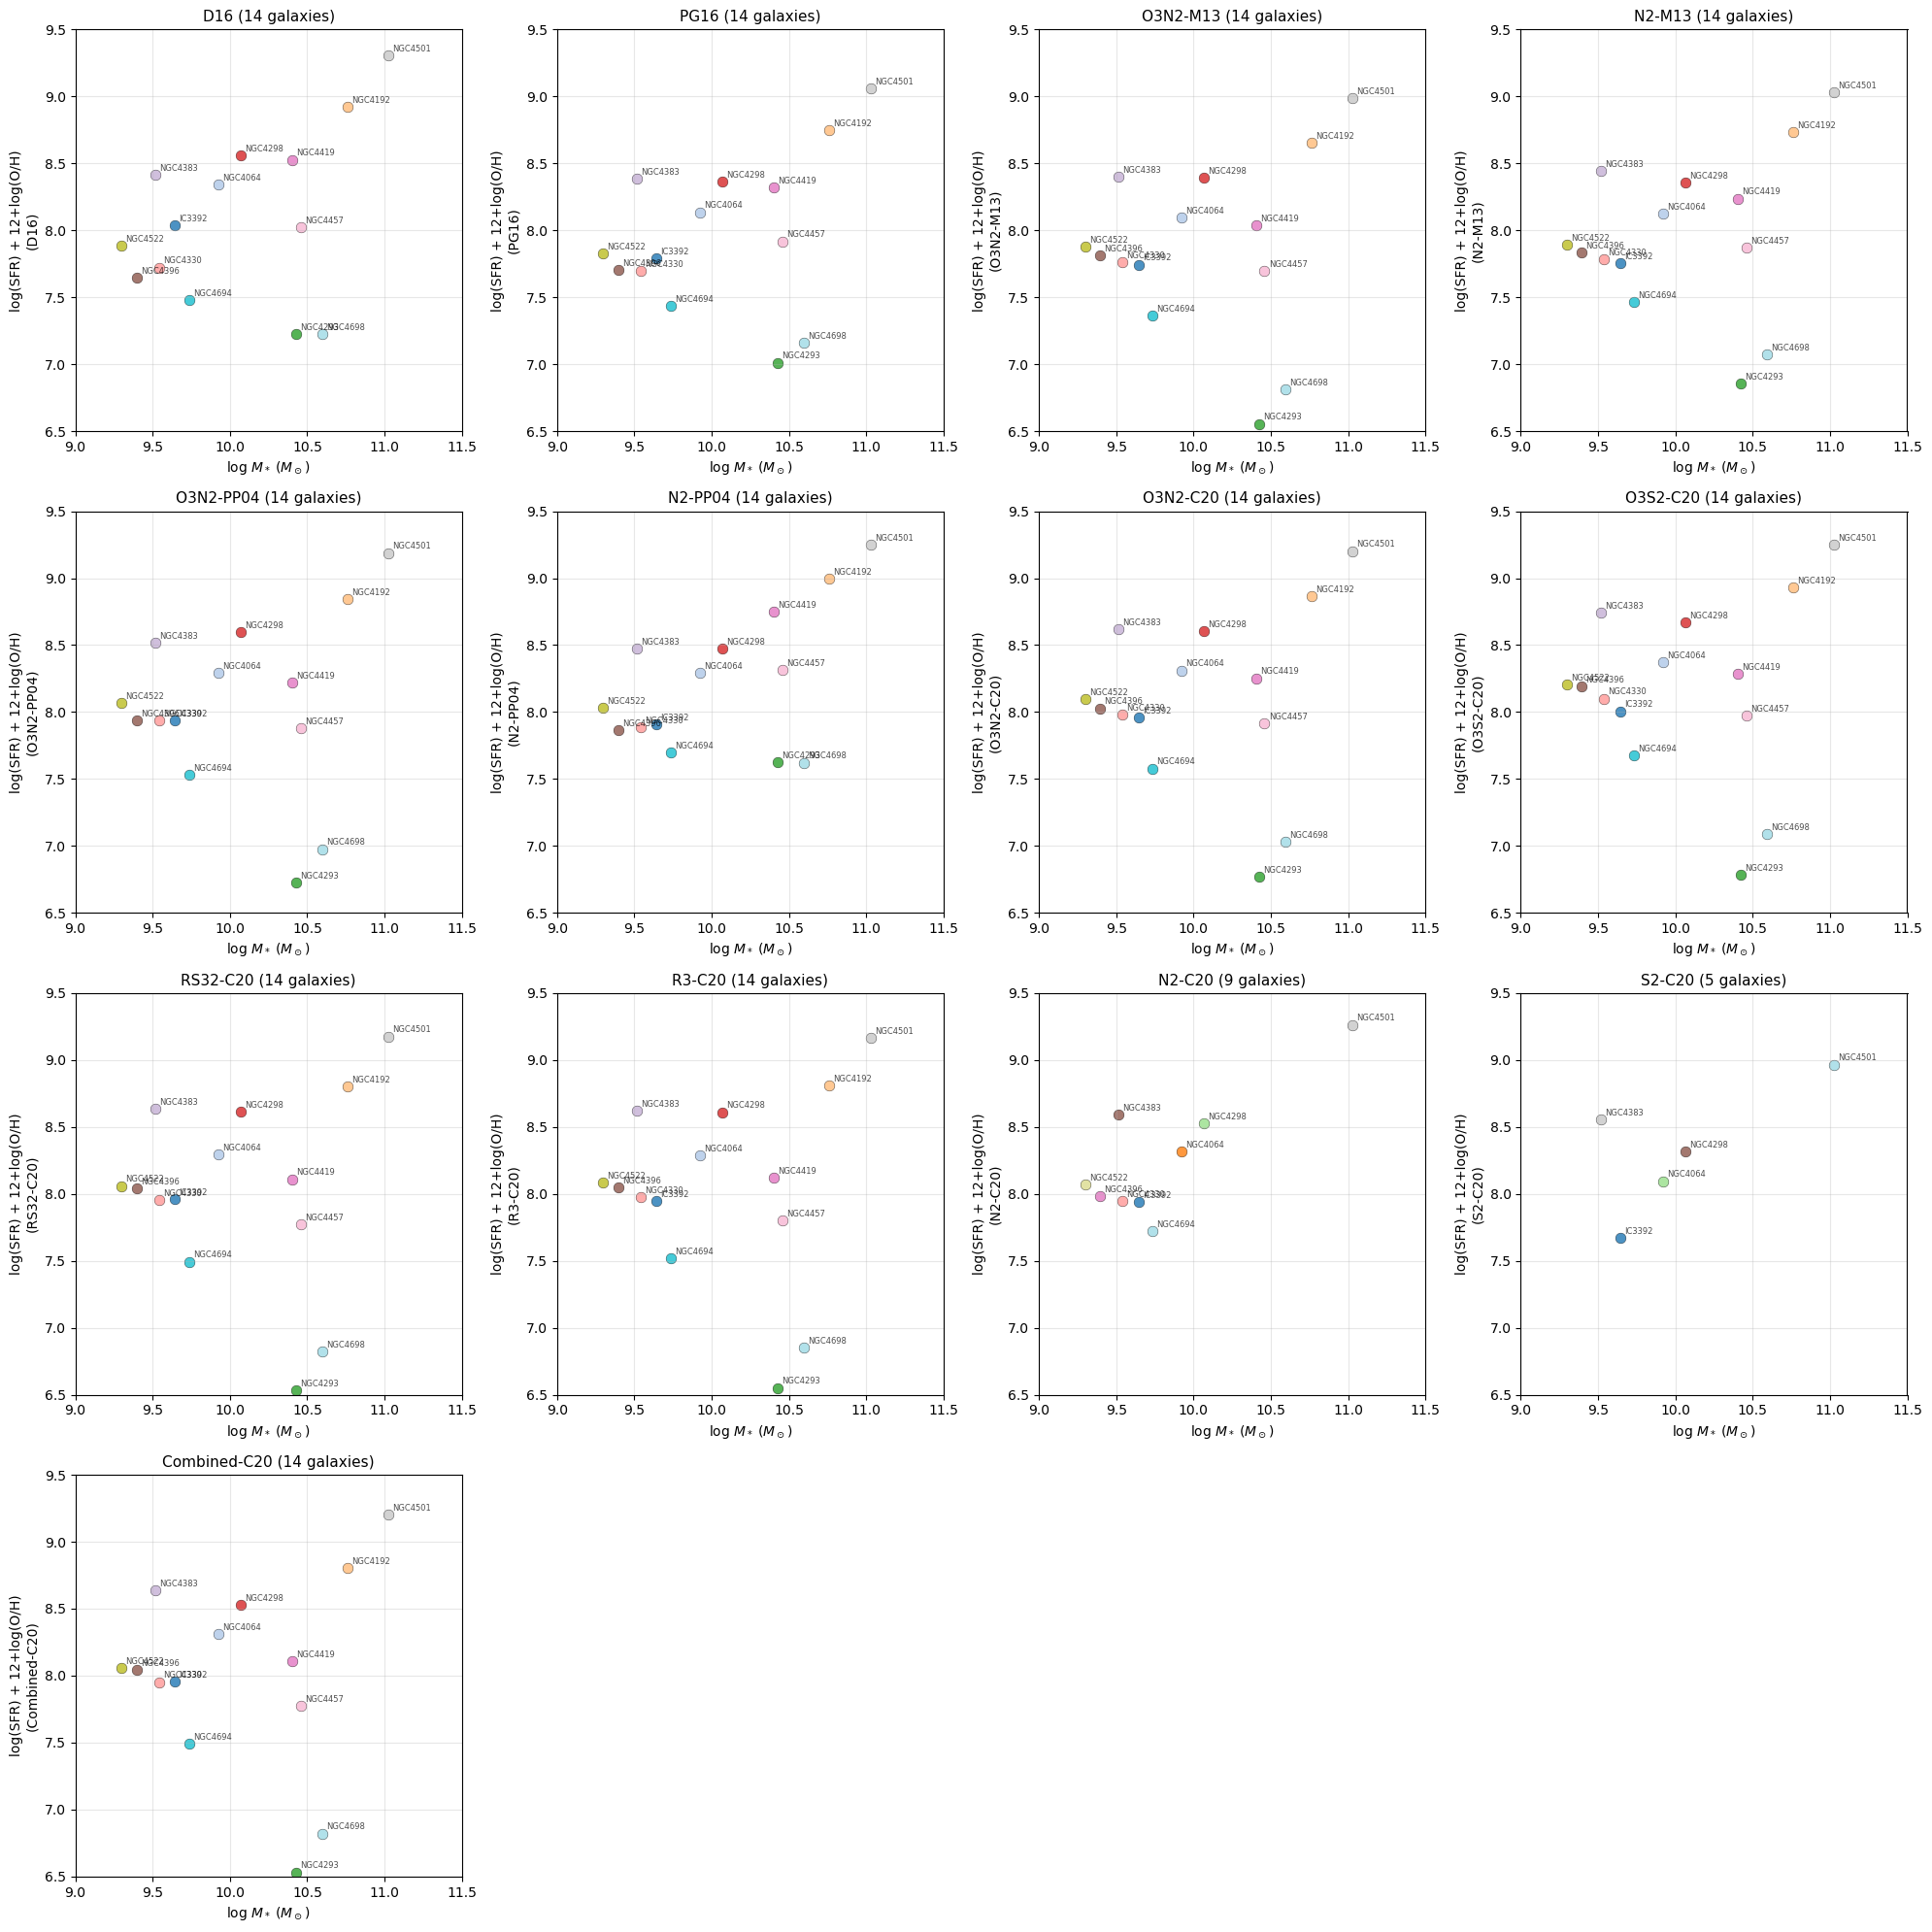


=== SUMMARY ===
Created plots for 13 metallicity calibrations
Each plot shows log(SFR) + (12 + log(O/H)) vs log(M_*) for the integrated case


In [16]:
# ------------------------------------------------------------------
# Loop through multiple metallicity calibrations: log(SFR) + (12 + log(O/H)) vs log(M_*)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from astropy.io import fits

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Define all the metallicity calibrations to loop through
metallicity_calibrations = [
    'D16', 'PG16', 'O3N2-M13', 'N2-M13', 'O3N2-PP04', 'N2-PP04', 
    'O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20', 'Combined-C20'
]

# Create extraction function for different metallicity calibrations
def extract_total_metallicity(galaxy_name, calibration):
    """Extract total metallicity for a specific calibration from log file."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        # Pattern for total region metallicity
        pattern = rf'\[O/H\] {re.escape(calibration)}: Total metallicity in total region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading {calibration} metallicity log for {galaxy_name}: {e}")
        return None

# Create a large figure with subplots for all calibrations
n_calibrations = len(metallicity_calibrations)
n_cols = 4  # 4 columns
n_rows = (n_calibrations + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each calibration
for idx, calibration in enumerate(metallicity_calibrations):
    ax = axes[idx]
    
    print(f"\nProcessing {calibration} calibration...")
    
    # Extract data for this calibration
    log_masses_cal = []
    log_sfrs_cal = []
    metallicities_cal = []
    galaxy_names_cal = []
    
    for gal in galaxies:
        mass = extract_total_stellar_mass(gal)
        sfr = extract_total_sfr(gal)
        metallicity = extract_total_metallicity(gal, calibration)
        
        if mass is not None and sfr is not None and metallicity is not None:
            log_masses_cal.append(mass)
            log_sfrs_cal.append(sfr)
            metallicities_cal.append(metallicity)
            galaxy_names_cal.append(gal)
    
    # Convert to numpy arrays
    log_masses_cal = np.array(log_masses_cal)
    log_sfrs_cal = np.array(log_sfrs_cal)
    metallicities_cal = np.array(metallicities_cal)
    
    if len(galaxy_names_cal) == 0:
        ax.text(0.5, 0.5, f'No data for {calibration}', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title(f'{calibration} (No Data)', fontsize=12)
        continue
    
    # Calculate the combined quantity: log(SFR) + (12 + log(O/H))
    combined_y_cal = log_sfrs_cal + metallicities_cal
    
    # Color-code each galaxy (consistent colors across all plots)
    colors_cal = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names_cal)))
    
    # Plot points
    for i, (mass, combined, gal) in enumerate(zip(log_masses_cal, combined_y_cal, galaxy_names_cal)):
        ax.scatter(mass, combined, s=60, c=[colors_cal[i]], alpha=0.8, 
                  edgecolors='black', linewidth=0.3)
        
        # Add galaxy name as annotation (smaller font for subplots)
        ax.annotate(gal, (mass, combined), xytext=(3, 3), textcoords='offset points', 
                   fontsize=6, alpha=0.7)
    
    # Formatting for each subplot
    ax.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=10)
    ax.set_ylabel(f'log(SFR) + 12+log(O/H)\n({calibration})', fontsize=10)
    ax.set_title(f'{calibration} ({len(galaxy_names_cal)} galaxies)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set consistent axis limits
    ax.set_xlim(9, 11.5)
    ax.set_ylim(6.5, 9.5)

# Hide any unused subplots
for idx in range(n_calibrations, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Created plots for {len(metallicity_calibrations)} metallicity calibrations")
print(f"Each plot shows log(SFR) + (12 + log(O/H)) vs log(M_*) for the integrated case")

## 3D plane from Curti20
$$\log_{10}(M) = m_0+m_1\log_{10}(\rm{SFR})-\frac{1}{\beta}\log_{10}(10^{\frac{\beta}{\gamma}(Z_0-Z)}-1)$$
with $Z_0 = 8.779$, $m_0 = 10.11$, $m_1 = 0.56$, $\gamma = 0.31$, $\beta = 2.1$


Processing D16 calibration...

Processing PG16 calibration...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66168/4040464016.py:42: RuntimeWarning: invalid value encountered in log10
  log_term = np.log10(10**exponent - 1)



Processing O3N2-M13 calibration...

Processing N2-M13 calibration...

Processing O3N2-PP04 calibration...

Processing N2-PP04 calibration...

Processing O3N2-C20 calibration...

Processing O3S2-C20 calibration...

Processing RS32-C20 calibration...

Processing R3-C20 calibration...

Processing N2-C20 calibration...

Processing S2-C20 calibration...

Processing Combined-C20 calibration...


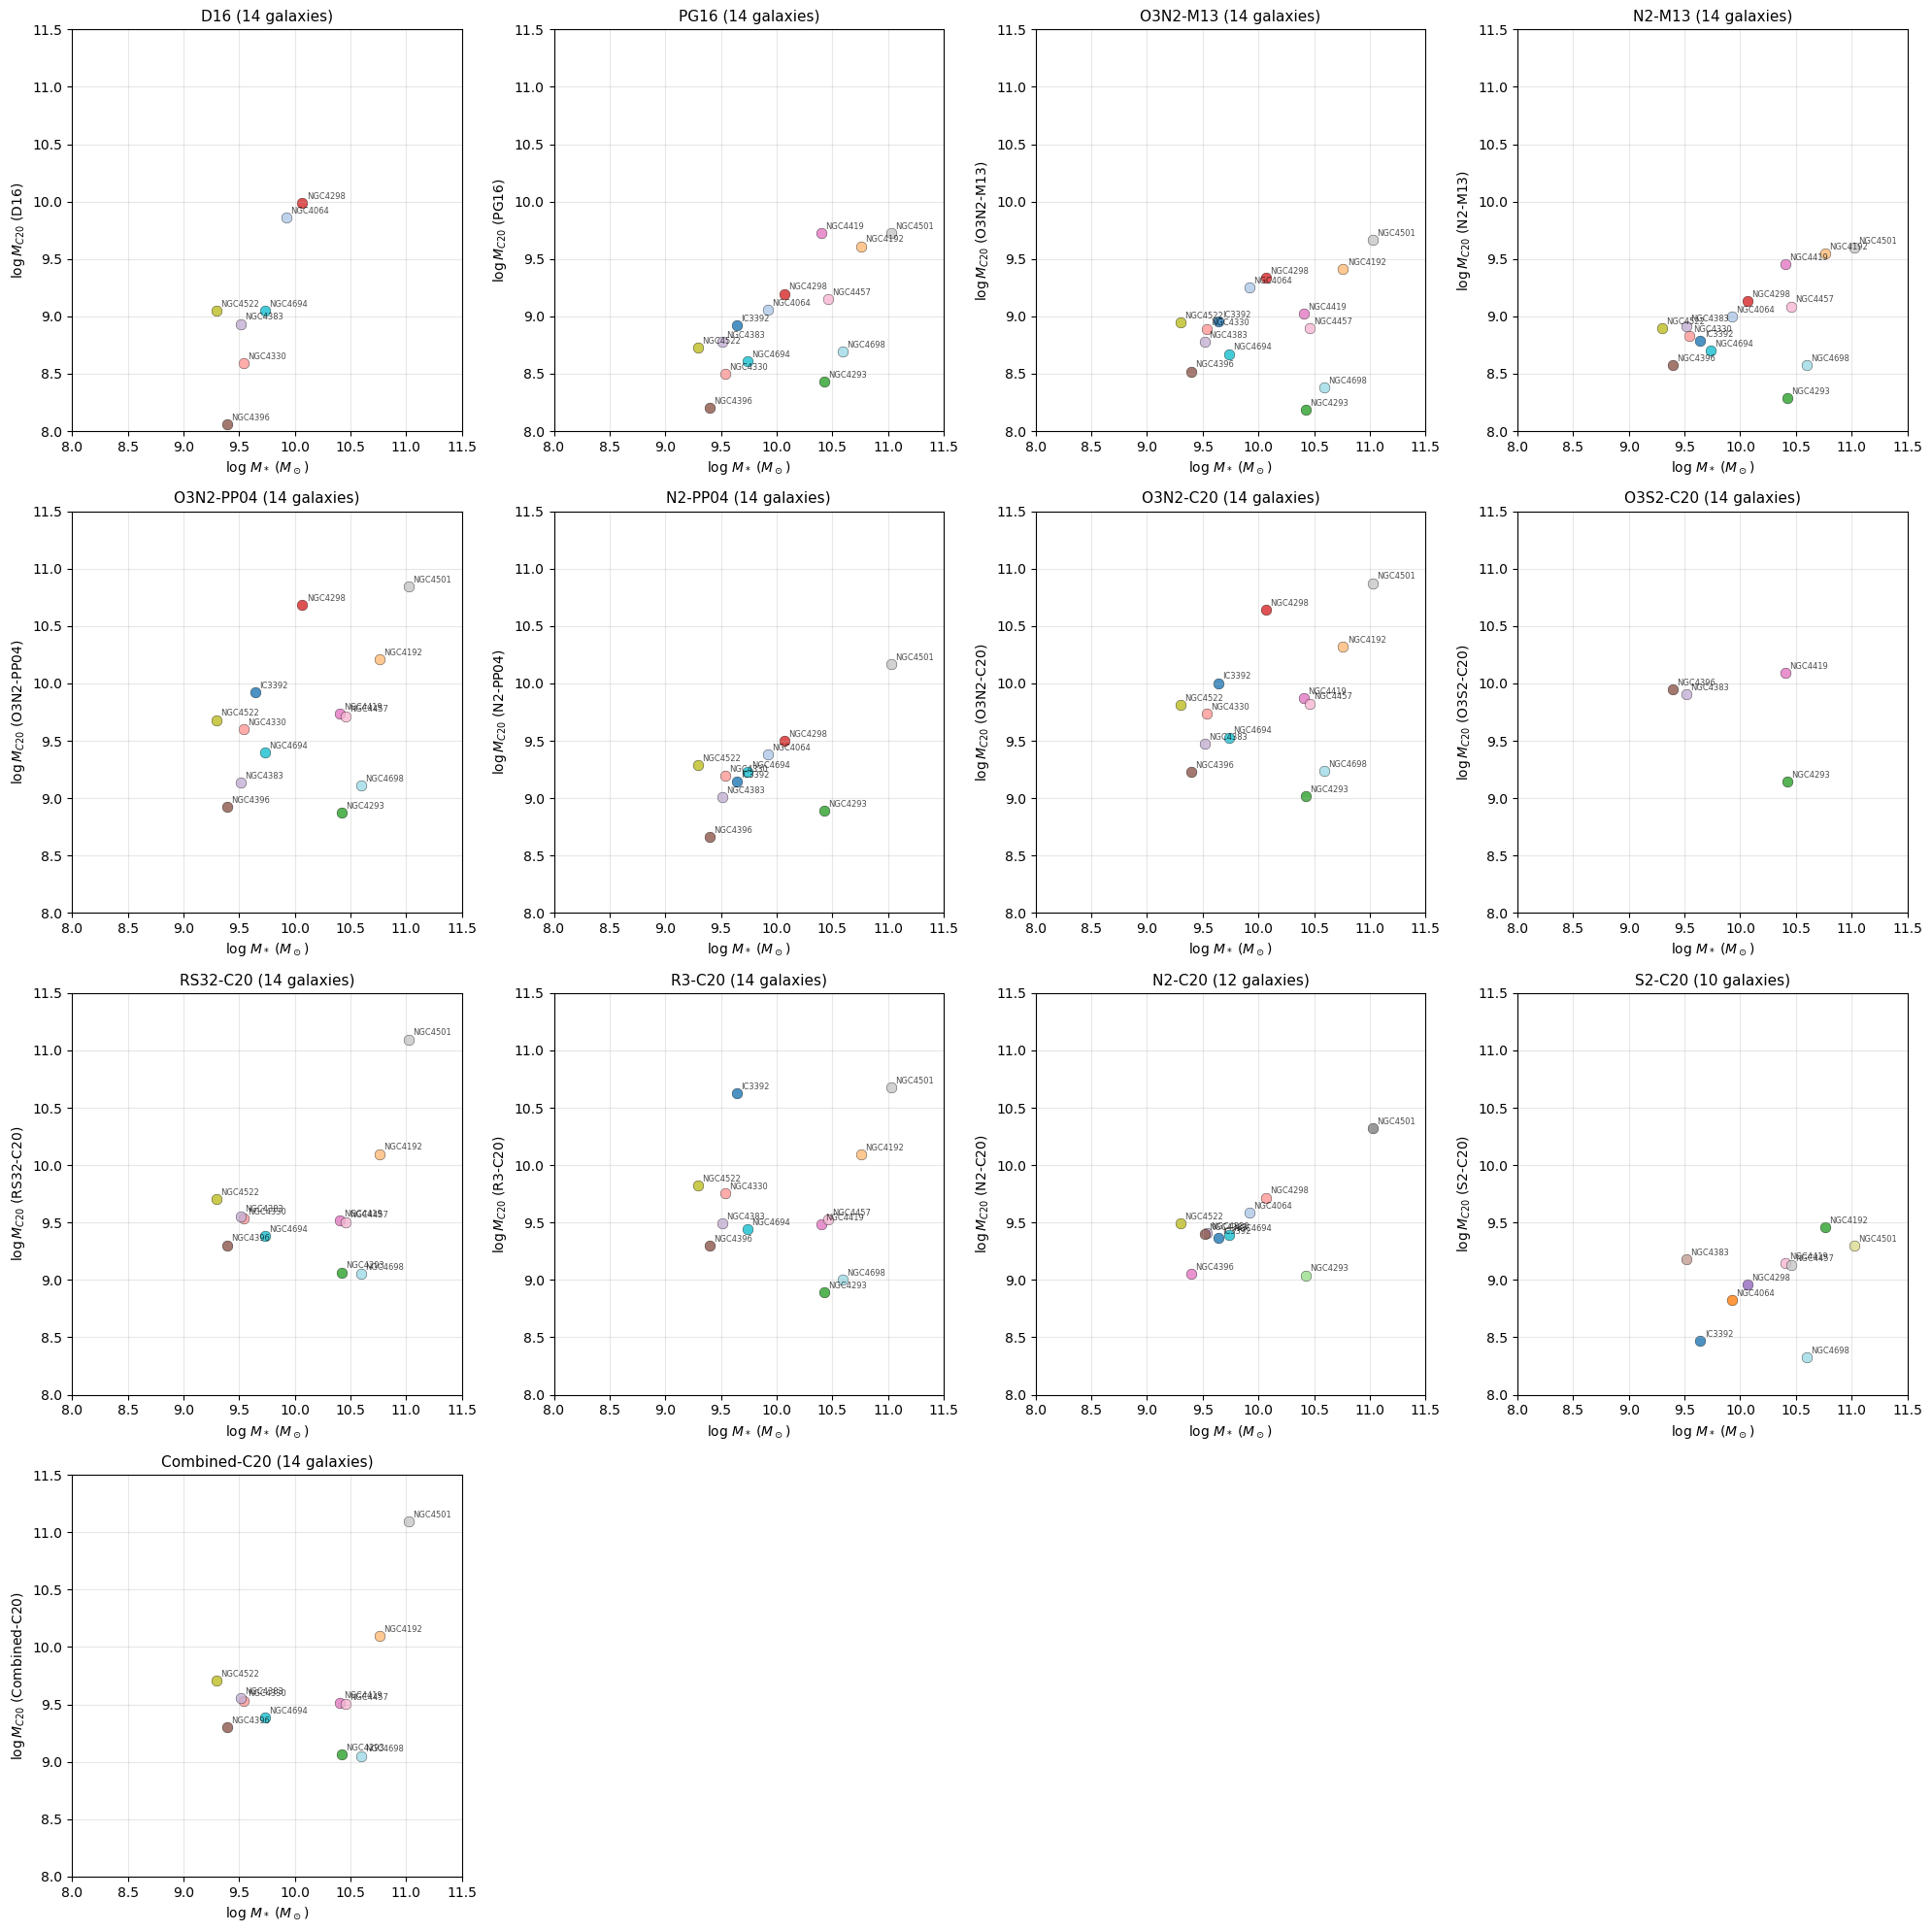


=== SUMMARY ===
Created plots for 13 metallicity calibrations
Each plot shows logM_C20 vs log(M_*) for the integrated case
logM_C20 formula: log10(M) = m0 + m1*log10(SFR) - (1/β)*log10(10^(β/γ*(Z0-Z)) - 1)
Parameters: Z0=8.779, m0=10.11, m1=0.56, γ=0.31, β=2.1


In [17]:
# ------------------------------------------------------------------
# Loop through multiple metallicity calibrations: logM_C20 vs log(M_*)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from astropy.io import fits

# Define all the metallicity calibrations to loop through
metallicity_calibrations = [
    'D16', 'PG16', 'O3N2-M13', 'N2-M13', 'O3N2-PP04', 'N2-PP04', 
    'O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20', 'Combined-C20'
]

# Define C20 formula parameters
Z0 = 8.779
m0 = 10.11
m1 = 0.56
gamma = 0.31
beta = 2.1

# Z0 = 8.782
# m0 = 10.39
# m1 = 0.454
# gamma = 0.299
# beta = 2.6

def calculate_logM_C20(log_sfr, metallicity):
    """
    Calculate log(M) using the C20 formula:
    log10(M) = m0 + m1*log10(SFR) - (1/beta)*log10(10^(beta/gamma*(Z0-Z)) - 1)
    
    Parameters:
    log_sfr: log10(SFR)
    metallicity: 12 + log(O/H)
    """
    Z = metallicity  # Z is 12 + log(O/H)
    
    # Calculate the C20 formula
    exponent = (beta / gamma) * (Z0 - Z)
    log_term = np.log10(10**exponent - 1)
    logM_C20 = m0 + m1 * log_sfr - (1/beta) * log_term
    
    return logM_C20

# Create extraction function for different metallicity calibrations
def extract_total_metallicity(galaxy_name, calibration):
    """Extract total metallicity for a specific calibration from log file."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        # Pattern for SF region metallicity
        pattern = rf'\[O/H\] {re.escape(calibration)} SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading {calibration} metallicity log for {galaxy_name}: {e}")
        return None

# Create a large figure with subplots for all calibrations
n_calibrations = len(metallicity_calibrations)
n_cols = 4  # 4 columns
n_rows = (n_calibrations + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each calibration
for idx, calibration in enumerate(metallicity_calibrations):
    ax = axes[idx]
    
    print(f"\nProcessing {calibration} calibration...")
    
    # Extract data for this calibration
    log_masses_cal = []
    log_sfrs_cal = []
    metallicities_cal = []
    galaxy_names_cal = []
    
    for gal in galaxies:
        mass = extract_total_stellar_mass(gal)
        sfr = extract_total_sfr(gal)
        metallicity = extract_total_metallicity(gal, calibration)
        
        if mass is not None and sfr is not None and metallicity is not None:
            log_masses_cal.append(mass)
            log_sfrs_cal.append(sfr)
            metallicities_cal.append(metallicity)
            galaxy_names_cal.append(gal)
    
    # Convert to numpy arrays
    log_masses_cal = np.array(log_masses_cal)
    log_sfrs_cal = np.array(log_sfrs_cal)
    metallicities_cal = np.array(metallicities_cal)
    
    if len(galaxy_names_cal) == 0:
        ax.text(0.5, 0.5, f'No data for {calibration}', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title(f'{calibration} (No Data)', fontsize=12)
        continue
    
    # Calculate logM_C20 using the C20 formula
    logM_C20_cal = calculate_logM_C20(log_sfrs_cal, metallicities_cal)
    
    # Color-code each galaxy (consistent colors across all plots)
    colors_cal = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names_cal)))
    
    # Plot points
    for i, (mass, logM_C20, gal) in enumerate(zip(log_masses_cal, logM_C20_cal, galaxy_names_cal)):
        ax.scatter(mass, logM_C20, s=60, c=[colors_cal[i]], alpha=0.8, 
                  edgecolors='black', linewidth=0.3)
        
        # Add galaxy name as annotation (smaller font for subplots)
        ax.annotate(gal, (mass, logM_C20), xytext=(3, 3), textcoords='offset points', 
                   fontsize=6, alpha=0.7)
    
    # Formatting for each subplot
    ax.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=10)
    ax.set_ylabel(f'$\\log M_{{C20}}$ ({calibration})', fontsize=10)
    ax.set_title(f'{calibration} ({len(galaxy_names_cal)} galaxies)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set consistent axis limits (adjusted for logM_C20 range)
    ax.set_xlim(8, 11.5)
    ax.set_ylim(8, 11.5)  # Adjusted y-axis range for logM_C20

# Hide any unused subplots
for idx in range(n_calibrations, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Created plots for {len(metallicity_calibrations)} metallicity calibrations")
print(f"Each plot shows logM_C20 vs log(M_*) for the integrated case")
print(f"logM_C20 formula: log10(M) = m0 + m1*log10(SFR) - (1/β)*log10(10^(β/γ*(Z0-Z)) - 1)")
print(f"Parameters: Z0={Z0}, m0={m0}, m1={m1}, γ={gamma}, β={beta}")